In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot

In [2]:
from pymongo import MongoClient
from pymongo.errors import ConnectionFailure

In [4]:
# loading data from parquet file
import os
file_path = os.path.join(os.getcwd(), 'yellow_tripdata_2024-05.parquet')

df = pd.read_parquet(file_path)


In [4]:
df.sample(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
2499708,1,2024-05-23 13:46:42,2024-05-23 14:05:20,1.0,1.80,1.0,N,143,162,4,17.00,2.5,0.5,0.00,0.00,1.0,21.00,2.5,0.0
3380126,2,2024-05-05 16:17:52,2024-05-05 16:23:47,NaN,1.24,NaN,NaN,236,236,0,13.78,0.0,0.5,0.00,0.00,1.0,17.78,NaN,NaN
1361050,1,2024-05-13 09:45:41,2024-05-13 10:12:27,1.0,2.30,1.0,N,236,100,1,21.20,2.5,0.5,5.00,0.00,1.0,30.20,2.5,0.0
972787,2,2024-05-09 18:07:08,2024-05-09 18:38:23,1.0,3.22,1.0,N,233,238,1,27.50,2.5,0.5,6.80,0.00,1.0,40.80,2.5,0.0
268669,2,2024-05-03 11:52:08,2024-05-03 12:38:08,1.0,13.73,1.0,N,233,123,1,62.50,0.0,0.5,14.69,6.94,1.0,88.13,2.5,0.0
2628963,2,2024-05-24 16:09:54,2024-05-24 17:08:18,6.0,4.53,1.0,N,236,211,1,47.80,2.5,0.5,30.00,0.00,1.0,84.30,2.5,0.0
1507268,2,2024-05-14 16:03:33,2024-05-14 16:07:02,2.0,0.53,1.0,N,236,263,1,5.80,0.0,0.5,1.50,0.00,1.0,11.30,2.5,0.0
309811,2,2024-05-03 18:52:57,2024-05-03 19:01:11,2.0,1.83,1.0,N,162,236,1,10.00,2.5,0.5,1.98,0.00,1.0,18.48,2.5,0.0
3229095,2,2024-05-31 09:29:52,2024-05-31 09:44:57,1.0,1.84,1.0,N,170,50,1,14.90,0.0,0.5,0.00,0.00,1.0,18.90,2.5,0.0
2031065,1,2024-05-18 22:45:09,2024-05-18 22:46:55,1.0,0.00,5.0,N,151,151,1,30.00,0.0,0.0,0.01,0.00,1.0,31.01,0.0,0.0


In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 3723833 entries, 0 to 3723832
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     str           
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            float64   

# Checking the null values 

In [6]:
na_count = df.isnull().sum()
na_pct = (
    df
    .isnull()
    .sum()
    .div(df.shape[0])
    .mul(100)
    .round(2)
    
)

(
    pd
    .concat([na_count, na_pct], axis=1)
    .set_axis(['Count', '%'], axis=1)
    .query('Count > 0')
    .sort_values('Count', ascending=False)
)

,Count,%
passenger_count,404666,10.87
RatecodeID,404666,10.87
store_and_fwd_flag,404666,10.87
congestion_surcharge,404666,10.87
Airport_fee,404666,10.87


## found around 10% of the data has null values

# Checking duplicate entires 

In [38]:
df.duplicated().sum()

np.int64(0)

# Now will be working with mongodb using pymongo

## Estabishing connection with mongo db

In [3]:
try:
    client = MongoClient("mongodb://localhost:27017/")

    db = client["birajit"]
    collection = db["taxidata"]

except Exception as e:
    print(e)



## Inserting the data using chunk as there are aorund 4M rows

In [16]:
CHUNK_SIZE = 25_000

for start in range(0, len(df), CHUNK_SIZE):
    chunk = df.iloc[start:start + CHUNK_SIZE]
    collection.insert_many(chunk.to_dict("records"), ordered=False)

In [41]:
# counting the documents 
collection.count_documents({})

3723833

# Questions:
1. What are the peak hours for taxi pickups?
2. What is the average trip distance by passenger count?
3. What is the distribution of payment types?
4. What are the top 10 days with the highest number of trips?
5. What is the total fare amount collected by each payment type?
6. What are the average trip distances for each hour of the day?
7. What is the distribution of trips by passenger count?

# 1. What are the peak hours for taxi pickups?

## solving using pandas

In [5]:
df['pickup_hour'] = df.tpep_pickup_datetime.dt.hour

<Axes: title={'center': 'Number of trips per hour'}, xlabel='pickup_hour'>

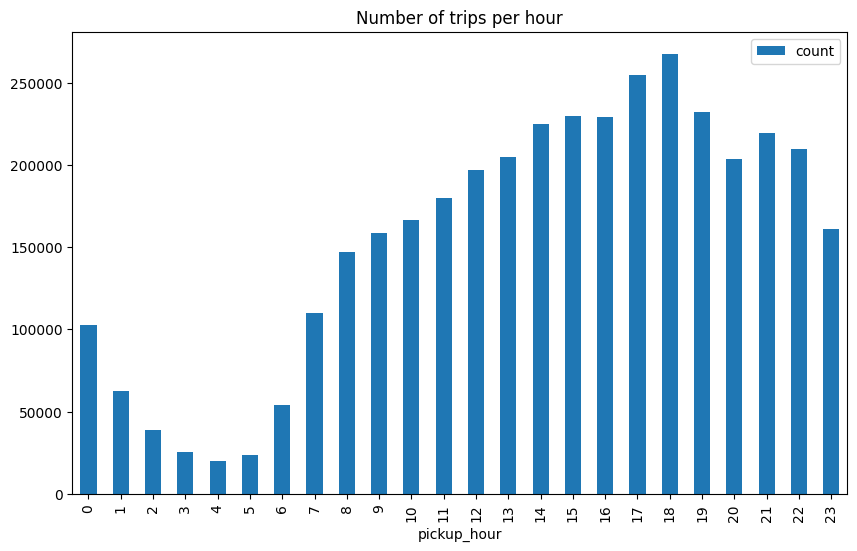

In [6]:
df.groupby('pickup_hour').aggregate(
    count = ('tpep_pickup_datetime', 'count')
).sort_index().plot(
    kind='bar',
    title='Number of trips per hour',
    figsize=(10, 6)
)

# Solving using mongodb query

<Axes: title={'center': 'Number of trips per hour'}>

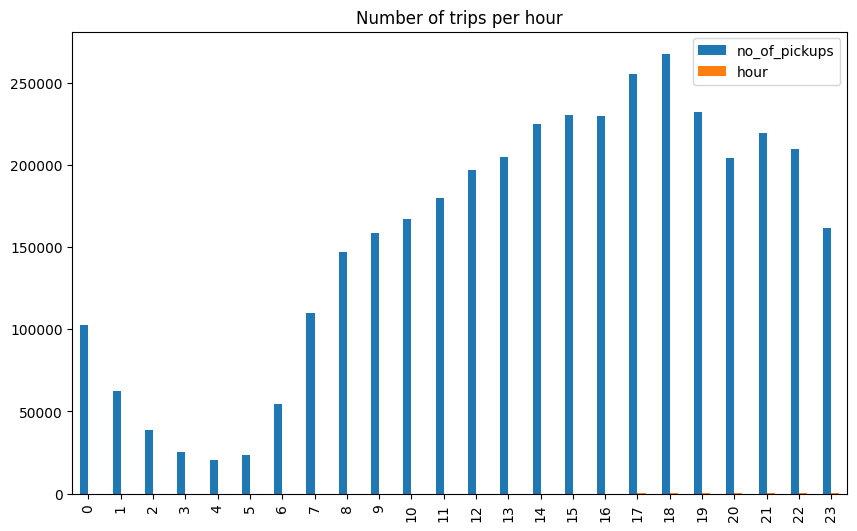

In [7]:
data = collection.aggregate(
    [
        {
            '$project': {
                "hour": {
                    "$hour": "$tpep_pickup_datetime"
                }
                
            }
        },
        {
            '$group':{
                "_id": '$hour',
                "no_of_pickups": {
                    '$count': {}
                }
            }
        },
        {
            '$sort': {
                '_id': 1
            }
        },
        {
            '$project':{
                '_id': 0,
                'hour': '$_id',
                'no_of_pickups': 1

            }
        }
    ]
)

pd.DataFrame(data).plot(
    kind='bar',
    title='Number of trips per hour',
    figsize=(10, 6)
)

# 2. What is the average trip distance by passenger count?#

<Axes: title={'center': 'Average trip distance by passenger count'}, xlabel='Passenger count', ylabel='Average trip distance'>

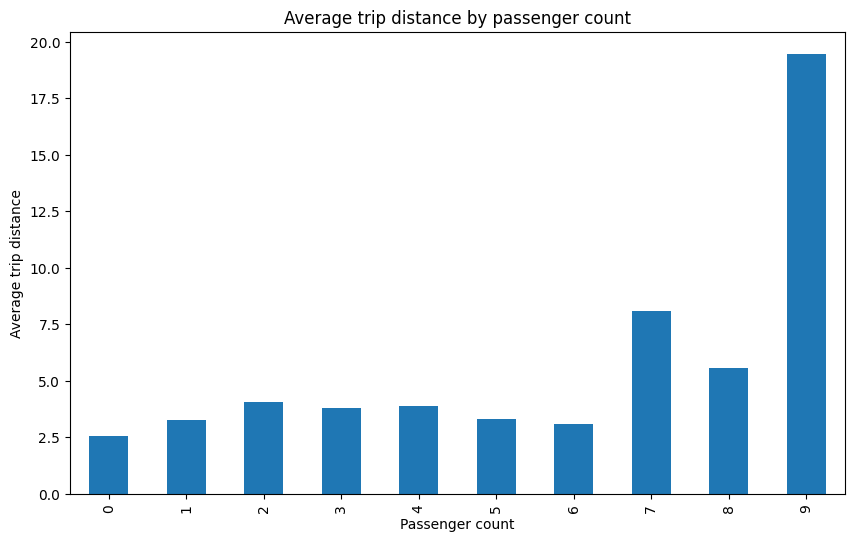

In [32]:
# # # solving using pandas

(
    df.groupby('passenger_count')
    .aggregate(
        avg_trip_dist = ('trip_distance','mean')
    )
    .reset_index()
    .assign(
        passenger_count = lambda x: x.passenger_count.astype(int)
    )
    .set_index('passenger_count')
).plot(
    kind='bar',
    title='Average trip distance by passenger count',
    figsize=(10, 6),
    ylabel='Average trip distance',
    xlabel='Passenger count',
    legend=False
)


In [34]:
q2 = collection.aggregate(
    [
         {
            "$match": {
                "$expr": {
                    "$and": [
                        {"$ne": ["$passenger_count", None]},
                        {"$ne": ["$passenger_count", float("nan")]},
                        {"$ne": ["$trip_distance", None]},
                        {"$ne": ["$trip_distance", float("nan")]}
                    ]
                },
                "passenger_count": {"$type": "number"},
                "trip_distance": {"$type": "number"}
            }
        },
        {
            '$group':{
                '_id': '$passenger_count', 'avg_trip_dist':{'$avg': '$trip_distance'}}
        },
        {
            '$project': {
                '_id': 0,
                'passenger_count': '$_id',
                'avg_trip_dist': 1
            }
        },
        {
            '$sort': { 'passenger_count': -1}
        }

    ]
)

pd.DataFrame(q2)

,avg_trip_dist,passenger_count
0,19.473333,9.0
1,5.581667,8.0
2,8.092500,7.0
3,3.077066,6.0
4,3.327658,5.0
5,3.875974,4.0
6,3.804252,3.0
7,4.070044,2.0
8,3.287827,1.0
9,2.576342,0.0


<Axes: title={'center': 'Average trip distance by passenger count'}, xlabel='Passenger count', ylabel='Average trip distance'>

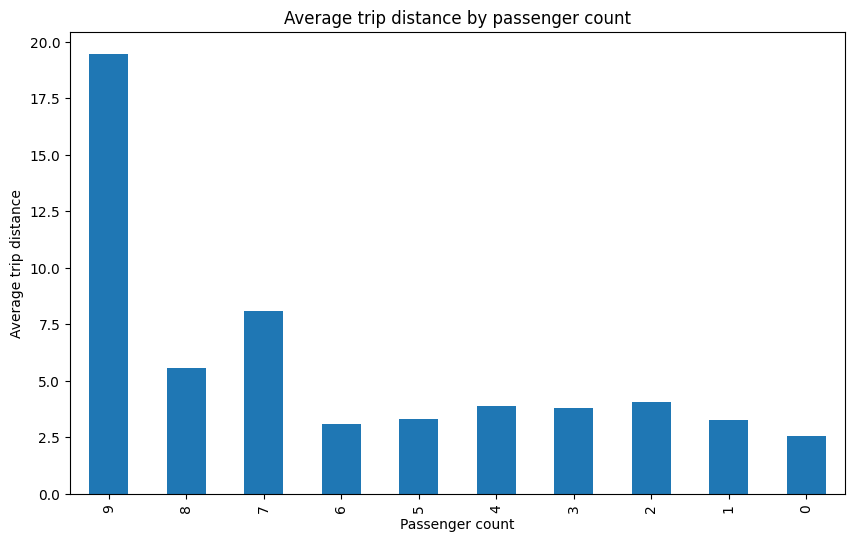

In [38]:
q2 = collection.aggregate(
    [
         {
            "$match": {
                'passenger_count': {
                    '$ne': np.nan      # this also works
                }
            }
        },
        {
            '$group':{
                '_id': '$passenger_count', 'avg_trip_dist':{'$avg': '$trip_distance'}}
        },
        {
            '$project': {
                '_id': 0,
                'passenger_count': '$_id',
                'avg_trip_dist': 1
            }
        },
        {
            '$sort': { 'passenger_count': -1}
        }

    ]
)

(pd.DataFrame(q2).set_index('passenger_count').assign(
    passenger_count = lambda x: x.index.astype(int)
).set_index('passenger_count')
.plot(
    kind='bar',
    title='Average trip distance by passenger count',
    figsize=(10, 6),
    ylabel='Average trip distance',
    xlabel='Passenger count',
    legend=False    
))

# 3. What is the distribution of payment types?

<Axes: title={'center': 'Distribution of payment types'}, xlabel='Payment type', ylabel='Count'>

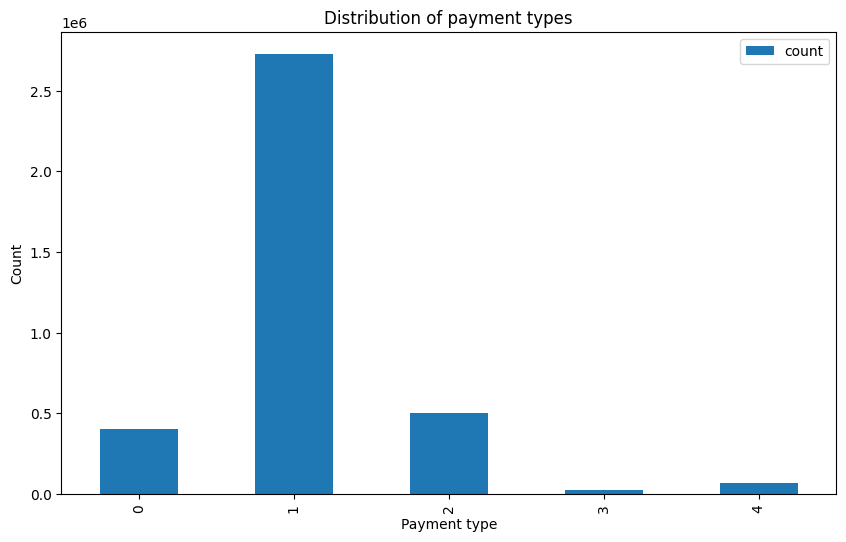

In [47]:
# using pandas
(
    df.groupby('payment_type')
    .aggregate(
        count = ('payment_type', 'count')
    )
).plot(
    kind='bar',
    title='Distribution of payment types',
    figsize=(10, 6),
    ylabel='Count',
    xlabel='Payment type'
)

<Axes: title={'center': 'Distribution of payment types'}, xlabel='Payment type', ylabel='Count'>

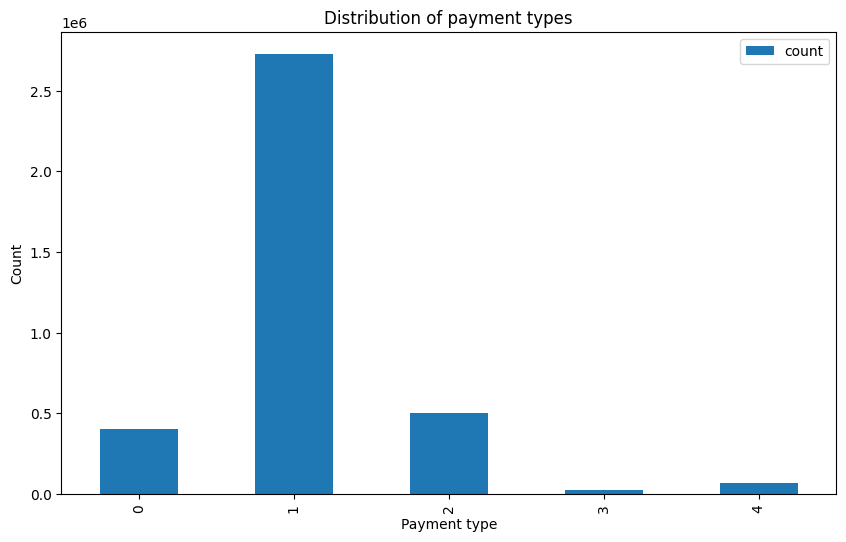

In [51]:
# solving using mongodb
q3 = collection.aggregate(
    [
        {
            '$group': {
                '_id': '$payment_type',
                'count': {'$count': {}}
            }
        },
    {
        '$project': {
            '_id': 0,
            'payment_type': '$_id',
            'count': 1
        },

    },
    {
        '$sort': {
            'payment_type': 1
        }
    }
    ]
)

(
    pd.DataFrame(q3)
    .set_index('payment_type')
    .plot(
    kind='bar',
    title='Distribution of payment types',
    figsize=(10, 6),
    ylabel='Count',
    xlabel='Payment type'
    )
)


# 4. What are the top 10 days with the highest number of trips?


<Axes: title={'center': 'Top 10 days with the highest number of trips'}, xlabel='Day of month', ylabel='Count'>

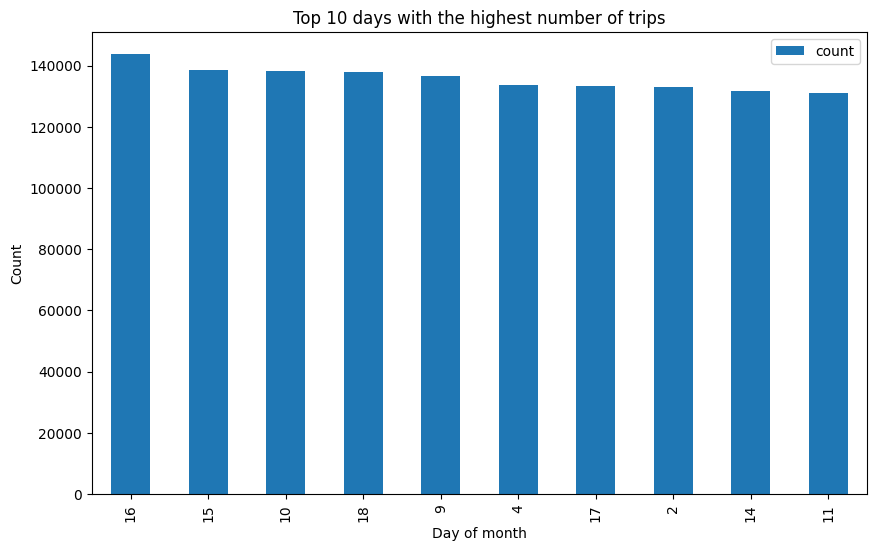

In [64]:
# using pandas

df['day_of_month'] = df.tpep_pickup_datetime.dt.day

(
    df.groupby('day_of_month')
    .aggregate(
        count = ('tpep_pickup_datetime', 'count')
    )
    .sort_values('count', ascending=False)
    .head(10)
).plot(
    kind='bar',
    title='Top 10 days with the highest number of trips',
    figsize=(10, 6),
    ylabel='Count',
    xlabel='Day of month'
)


<Axes: title={'center': 'Top 10 days with the highest number of trips'}, xlabel='Day of month', ylabel='Count'>

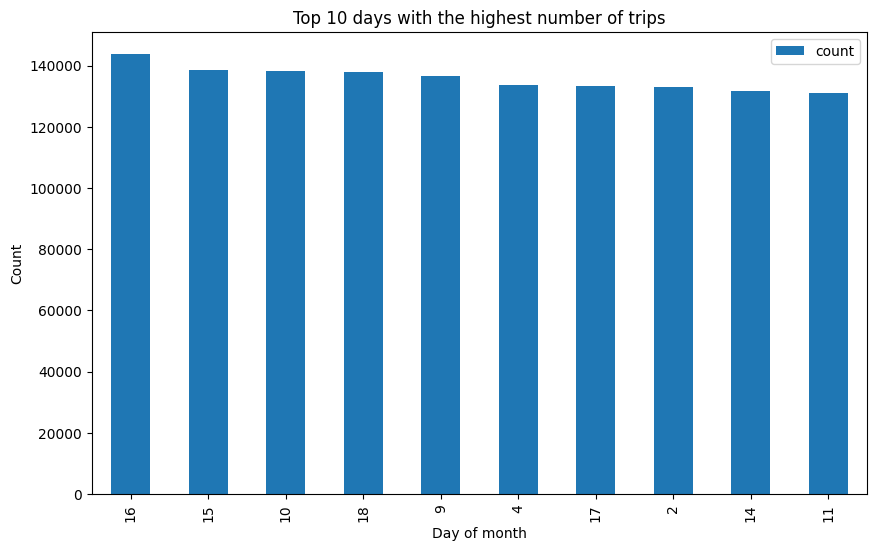

In [65]:
# solving using mongodb
q4 = collection.aggregate(
    [
       {
        '$project': {
            'day_of_month': {
                '$dayOfMonth': '$tpep_pickup_datetime'
            }
        }
       },
       {
        '$group': {
            '_id': '$day_of_month',
            'count': {'$count':{}}
        }
       },
       {
        '$project':{
            '_id': 0,
            'day_of_month':'$_id',
            'count': 1
        }
       },
       {
        '$sort': {
            'count': -1
        }
       },
       {
        '$limit': 10
       }
    ]
)

pd.DataFrame(q4).set_index('day_of_month').plot(
    kind='bar',
    title='Top 10 days with the highest number of trips',
    figsize=(10, 6),
    ylabel='Count',
    xlabel='Day of month'
)

# 5. What is the total fare amount collected by each payment type?

<Axes: title={'center': 'total amount per payement type'}, xlabel='Payment Type', ylabel='Total'>

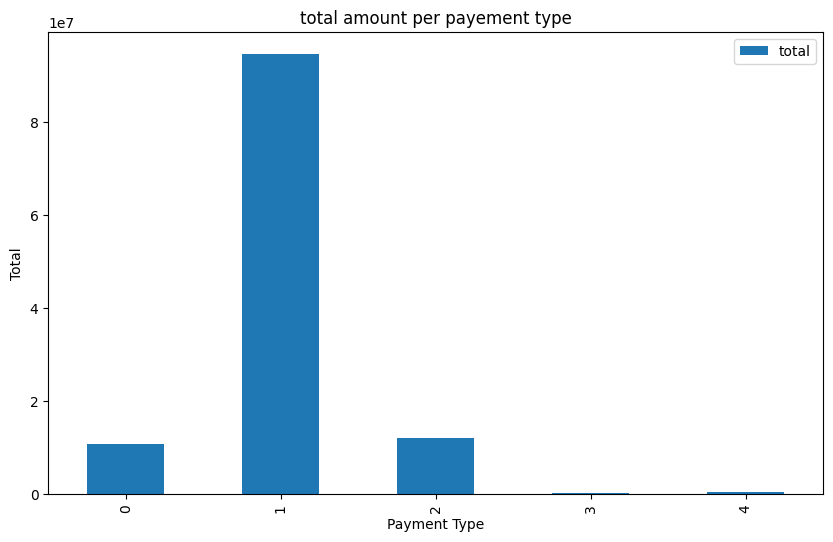

In [76]:
# using pandas
(
    df.groupby(
        'payment_type'
    ).aggregate(
        total_amount = ('total_amount', 'sum'),
        total_tip = ('tip_amount', 'sum')

    )
    .assign(
        total = lambda x: x['total_amount'] + x['total_tip']
    )[['total']]
).plot(
    kind='bar',
    title='total amount per payement type',
    figsize=(10, 6),
    ylabel='Total',
    xlabel='Payment Type'
)


<Axes: title={'center': 'total amount per payement type'}, xlabel='Payment Type', ylabel='Total'>

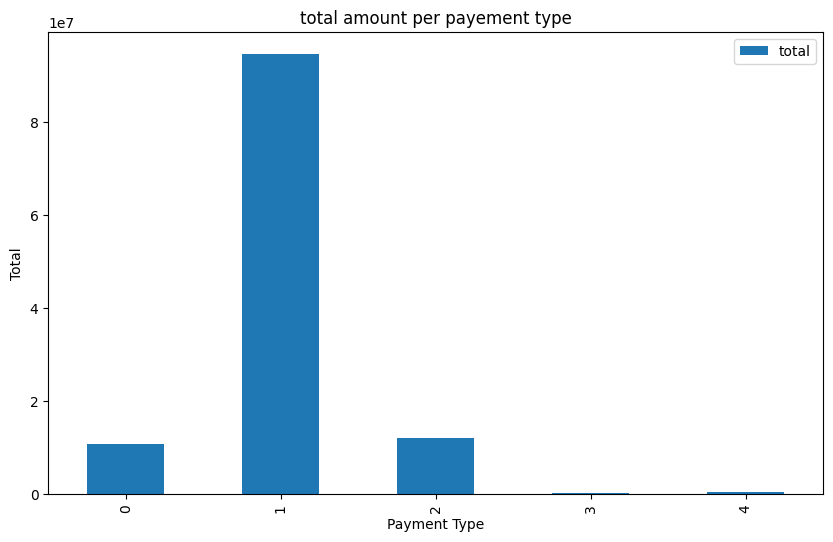

In [89]:
# using mongodb

q5 = collection.aggregate([
    {
        '$group':{
            '_id': '$payment_type',
            'total': {
                '$sum':{
                    '$add': ['$total_amount', '$tip_amount']
                }
            }
        }
    },
    {
        '$project':{
            '_id': 0,
            'payment_type': '$_id',
            'total': 1
        }
    },
    {
        '$sort':{
            'payment_type': 1
        }
    }
    
])

(
    pd.DataFrame(q5)
    .set_index('payment_type')
    .plot(
         kind='bar',
        title='total amount per payement type',
        figsize=(10, 6),
        ylabel='Total',
        xlabel='Payment Type'
    )
)

# 6. What are the average trip distances for each hour of the day?


<Axes: xlabel='pickup_hour'>

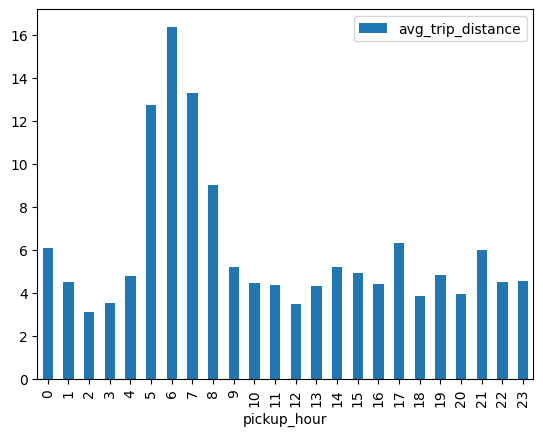

In [95]:
# using pandas
df['pickup_hour'] = df.tpep_pickup_datetime.dt.hour 

df.groupby(
    'pickup_hour'
).aggregate(
    avg_trip_distance = ('trip_distance', 'mean')
).plot(
    kind='bar'
)

<Axes: xlabel='hour'>

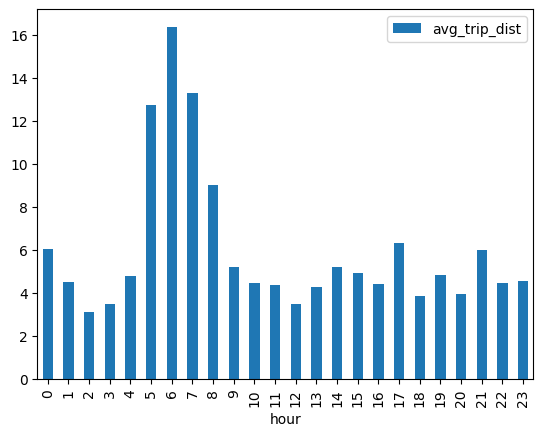

In [105]:
# using mongodb

q6 = collection.aggregate([
     {
        '$project': {
            "hour": {
                "$hour": "$tpep_pickup_datetime"
            },
            'trip_distance': 1
            
        }
    },
    {
        '$group':{
            '_id': '$hour',
            'avg_trip_dist':{'$avg': '$trip_distance'}
        }

    },
    {
        '$project': {
            '_id': 0,
            'hour': '$_id',
            'avg_trip_dist': 1
            
        }
    },
    {
        '$sort':{
            'hour': 1
        }
    }
])

pd.DataFrame(q6).set_index('hour').plot(kind='bar')

# 7. What is the distribution of trips by passenger count?

<Axes: xlabel='passenger_count'>

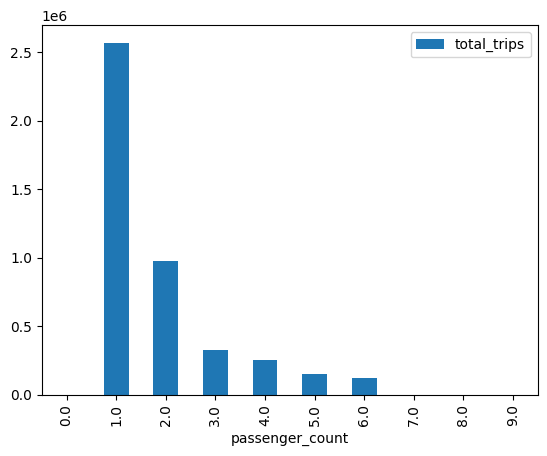

In [110]:
# using pandas

(
    df.groupby(
        'passenger_count'
    ).aggregate(
        total_trips = ('passenger_count', 'sum')
    ).plot(kind='bar')
)

<Axes: xlabel='passenger_count'>

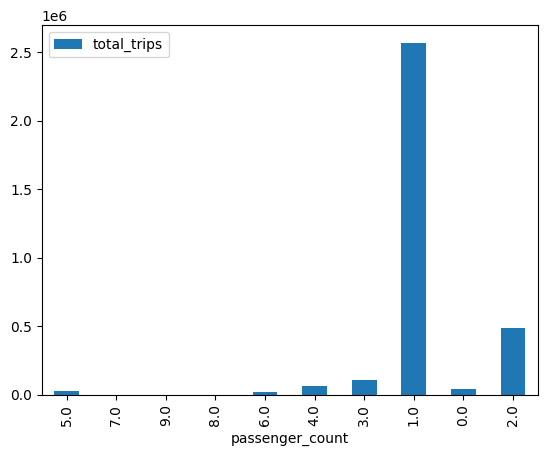

In [116]:
# using mongodb

q7 = collection.aggregate([
    {
        '$group':{
            '_id': '$passenger_count',
            'total_trips': {'$count': {}}
        }
    },
    {
        '$match': {
            '_id': {'$ne':np.nan}
        }
    },
    {
        '$project': {
            '_id': 0,
            'passenger_count': '$_id',
            'total_trips': 1
        }
    }
])

pd.DataFrame(q7).set_index(
    'passenger_count'
).plot(
    kind='bar'
)